# Refining Top Two Predictive Models for Titanic

After my last submission, where I was roughly top 10 percentile, I wanted to explore some of the techniques I learned for feature engineering and assessment to potentially create a more accurate predictive model for the Titanic competition. I'll be focusing on trying to improve the accuracy of my Gradient-Boost Trees (GBT) and CatBoost models. I'll employ additional feature engineering since I already have such few features in the models.

I carried over the data from my original submission after performing my feature engineering. 

X_train is the final set! y_train is the outcomes! test is the accuracy. 

In [1]:
import numpy as np
import pandas as pd

import os
import sys

import matplotlib.pyplot as plt
import missingno
import seaborn as sbrn

from sklearn.preprocessing import OneHotEncoder, label_binarize

import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, datasets, linear_model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier, Pool, cv

## Importing My Datasets

I'm going to be loading the training and test dataset from my initial submission. 

In [2]:
os.getcwd()

'C:\\Users\\Steven S-C\\Desktop\\Kaggle Competitions\\Titanic_ Machine Learning from Disaster'

In [5]:
train = pd.read_csv(r"C:\\Users\\Steven S-C\\Desktop\\Kaggle Competitions\\Titanic_ Machine Learning from Disaster\\train.csv")
X_train = pd.read_csv(r"C:\\Users\\Steven S-C\\Desktop\\Kaggle Competitions\\Titanic_ Machine Learning from Disaster\\X_train.csv")
y_train = pd.read_csv(r"C:\\Users\\Steven S-C\\Desktop\\Kaggle Competitions\\Titanic_ Machine Learning from Disaster\\y_train.csv")
test = pd.read_csv(r"C:\\Users\\Steven S-C\\Desktop\\Kaggle Competitions\\Titanic_ Machine Learning from Disaster\\test.csv")

In [6]:
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


## New Fatures

From my original submission I created/manipulated features for: Siblings onboard, children onboard, fare, cabin, and port of embarkment. I would like ot explore age and naming convention.

## Feature: Age

For age, I thought it would be interesting to have categorical variables for child, adult, and elderly, as I suspect these categories probably affected survivorship due to priority treatment for escape from the Titanic. As of now, I'll define child as age<18, adult as 17<age<44, and elderly as 44<age. I based the elderly age based on the life expectancy of those living in 1990.

Before going along with these cut offs, let's explore the distribution of age.

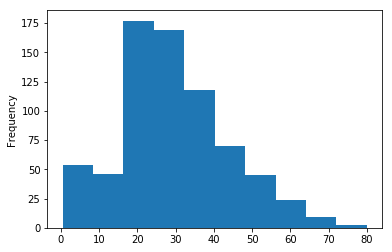

In [5]:
train.Age.plot.hist()

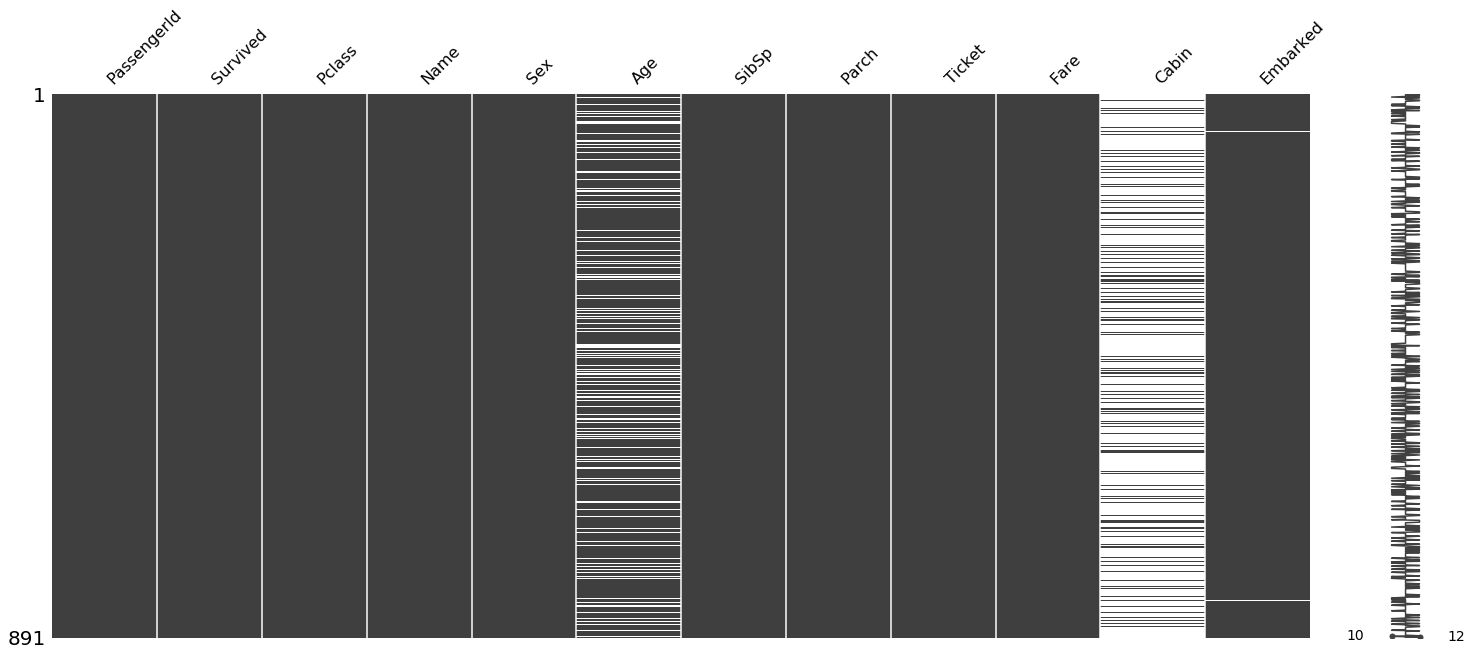

In [6]:
missingno.matrix(train)

Given the way it's distributed visually, I might set the cut off at 40 for elderly since it's not too far from my original cutoff and there seems to be a big different in frequency between the 30's bin and the 40's bin. 

As from before, Age has 177 missing variables. I might create an additional binary variables that takes advantage of this information; Child, Elderly, and Age-Not-Missing. 

In [7]:
## Creating age category variable
X_train['AgeGroup'] = pd.cut(train['Age'], [0, 18, 40, 80], labels=['Child','Adult', 'Elderly'], right=False)

X_train.head(15)

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3,AgeGroup
0,1,0,7.2500,0,0,1,0,1,0,0,1,Adult
1,1,0,71.2833,1,0,0,1,0,1,0,0,Adult
2,0,0,7.9250,0,0,1,1,0,0,0,1,Adult
3,1,0,53.1000,0,0,1,1,0,1,0,0,Adult
4,0,0,8.0500,0,0,1,0,1,0,0,1,Adult
5,0,0,8.4583,0,1,0,0,1,0,0,1,NaN
6,0,0,51.8625,0,0,1,0,1,1,0,0,Elderly
7,3,1,21.0750,0,0,1,0,1,0,0,1,Child
8,0,2,11.1333,0,0,1,1,0,0,0,1,Adult
9,1,0,30.0708,1,0,0,1,0,0,1,0,Child


With this information, we can now hot encode the "Age Group" variable for Child, Adult, Elderly. We'll ignore the missing age variables for now.

In [8]:
df_agegroup_cat = pd.get_dummies(X_train['AgeGroup'],
                               prefix='AgeGroup')

I'll also create a variable to denote whether or not their age was available so that we can take advantage of the missing data for Age.

In [10]:
df_agegroup_cat['AgeAvail'] = X_train['AgeGroup']

df_agegroup_cat['AgeAvail'] = df_agegroup_cat['AgeAvail'].replace(np.nan, '0')
df_agegroup_cat['AgeAvail'] = df_agegroup_cat['AgeAvail'].str.replace('.*A+.*', '1')
df_agegroup_cat['AgeAvail'] = df_agegroup_cat['AgeAvail'].str.replace('.*C+.*', '1')
df_agegroup_cat['AgeAvail'] = df_agegroup_cat['AgeAvail'].str.replace('.*E+.*', '1')

In [12]:
df_ageavail_onehot = pd.get_dummies(df_agegroup_cat['AgeAvail'],
                                   prefix='AgeAvail')

X_train = pd.concat([X_train,
                    df_agegroup_cat,
                    df_ageavail_onehot], axis=1)
X_train = X_train.drop(['AgeAvail', 'AgeGroup'], axis=1)

## Feature: Name

I wanted to stay away from this variable because it is quite a messy variable. From exploration, we might be able to extract patterns from the names we're seeing.

In [14]:
train.Name.head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

There seems to be a few things that can be extracted here. The people's titles can give us insight into marital status for women and social standing based off their titles like, "Master." I see that the titles are '.' separated, so I'll extract those into a new variable. 

In [16]:
def name_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'None'

In [17]:
X_train['Title'] = train['Name'].map(lambda x: name_title(x))
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3,AgeGroup_Child,AgeGroup_Adult,AgeGroup_Elderly,AgeAvail_0,AgeAvail_1,Title
0,1,0,7.2500,0,0,1,0,1,0,0,1,0,1,0,0,1,Mr
1,1,0,71.2833,1,0,0,1,0,1,0,0,0,1,0,0,1,Mrs
2,0,0,7.9250,0,0,1,1,0,0,0,1,0,1,0,0,1,Miss
3,1,0,53.1000,0,0,1,1,0,1,0,0,0,1,0,0,1,Mrs
4,0,0,8.0500,0,0,1,0,1,0,0,1,0,1,0,0,1,Mr


In [18]:
df_nametitle_onehot = pd.get_dummies(X_train['Title'],
                                    prefix='title')

X_train = pd.concat([X_train,
                    df_nametitle_onehot], axis=1)

X_train = X_train.drop(['Title'], axis=1)

In [19]:
pd.set_option('display.max_columns', 40)
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3,AgeGroup_Child,AgeGroup_Adult,AgeGroup_Elderly,AgeAvail_0,AgeAvail_1,title_Capt,title_Col,title_Don,title_Dr,title_Jonkheer,title_Lady,title_Major,title_Master,title_Miss,title_Mlle,title_Mme,title_Mr,title_Mrs,title_Ms,title_Rev,title_Sir,title_the Countess
0,1,0,7.2500,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,0,71.2833,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,1,0,53.1000,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


Looking at the titles in the dataset, we're capturing a lot of information about the passengers! We're capturing marital status, profession, social standing, military involvement, class, etc. 

## Testing GBT and CatBoost

First, I'm going to carry over the function used to train the models from my initial submission. Then we'll run both models and evaluate their performance.

In [60]:
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train.values.ravel())
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    
    
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    confus_matr = metrics.confusion_matrix(y_train, train_pred)
    precision = precision_score(y_train, train_pred)
    recall = recall_score(y_train, train_pred)
    F1 = f1_score(y_train, train_pred)
    auc = roc_auc_score(y_train, train_pred)
    
    return model, train_pred, acc, acc_cv, confus_matr, precision, recall, F1, auc

### Gradient Boost Trees (GBT)

In [61]:
GBT_model, train_pred_gbt, acc_gbt, acc_cv_gbt, cfmt_gbt, prec_gbt, rec_gbt, F1_gbt, auc_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                                               X_train, 
                                                                                               y_train,
                                                                                               10)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Confusion Matrix: %s" % cfmt_gbt)
print("Precision: ", float("{0:.3f}".format(round(prec_gbt, 3))))
print("Recall: ", float("{0:.3f}".format(round(rec_gbt, 3))))
print("F1 Score: ", float("{0:.3f}".format(round(F1_gbt, 3))))
print("AUC: ", float("{0:.3f}".format(round(auc_gbt, 3))))

Accuracy: 89.0
Accuracy CV 10-Fold: 83.28
Confusion Matrix: [[496  53]
 [ 96 246]]
Precision:  0.823
Recall:  0.719
F1 Score:  0.768
AUC:  0.811


As a reminder of the results I got from my initial submission:<br>
Accuracy: 87.21<br>
Accuracy CV 10-Fold: 81.26<br>
Confusion Matrix: [[494 55]<br>
[112 230]]<br>
Precision: 0.807<br>
Recall: 0.673<br>
F1 Score: 0.734<br>
AUC: 0.786<br>

It seems the additional feature engineering has improved the model's performance and hopefully that translates to better prediction accuracy. 

### CatBoost Algorithm

Here I will follow the same steps I performed in my initial submission to set up the data for CatBoost.

In [34]:
## Remove non-categorical variables
cat_features = np.where(X_train.dtypes != np.float)[0]

In [35]:
## Pool combines our values from training data
train_pool = Pool(X_train,
                 y_train,
                 cat_features)

In [28]:
# CatBoost model 
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=False)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

Learning rate set to 0.016216
0:	learn: 0.6824594	total: 106ms	remaining: 1m 45s
1:	learn: 0.6725634	total: 149ms	remaining: 1m 14s
2:	learn: 0.6628088	total: 192ms	remaining: 1m 3s


3:	learn: 0.6547712	total: 234ms	remaining: 58.3s
4:	learn: 0.6460972	total: 276ms	remaining: 54.9s
5:	learn: 0.6377220	total: 314ms	remaining: 52.1s
6:	learn: 0.6325742	total: 335ms	remaining: 47.5s
7:	learn: 0.6237993	total: 370ms	remaining: 45.9s
8:	learn: 0.6168296	total: 399ms	remaining: 43.9s
9:	learn: 0.6090992	total: 446ms	remaining: 44.2s
10:	learn: 0.6032590	total: 473ms	remaining: 42.5s
11:	learn: 0.5971001	total: 525ms	remaining: 43.2s
12:	learn: 0.5901544	total: 560ms	remaining: 42.6s
13:	learn: 0.5833427	total: 604ms	remaining: 42.6s
14:	learn: 0.5784287	total: 654ms	remaining: 43s
15:	learn: 0.5721524	total: 695ms	remaining: 42.7s
16:	learn: 0.5679421	total: 723ms	remaining: 41.8s
17:	learn: 0.5640241	total: 765ms	remaining: 41.7s
18:	learn: 0.5588295	total: 821ms	remaining: 42.4s
19:	learn: 0.5555790	total: 860ms	remaining: 42.1s
20:	learn: 0.5501734	total: 899ms	remaining: 41.9s
21:	learn: 0.5445035	total: 939ms	remaining: 41.8s
22:	learn: 0.5402515	total: 981ms	remain

In [29]:
# Set params for cross-validation
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=False)


# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

0:	learn: 0.6779261	test: 0.6781514	best: 0.6781514 (0)
1:	learn: 0.6614804	test: 0.6620923	best: 0.6620923 (1)
2:	learn: 0.6465766	test: 0.6476679	best: 0.6476679 (2)
3:	learn: 0.6324641	test: 0.6344052	best: 0.6344052 (3)
4:	learn: 0.6196254	test: 0.6222290	best: 0.6222290 (4)
5:	learn: 0.6074642	test: 0.6106360	best: 0.6106360 (5)
6:	learn: 0.5961357	test: 0.6000295	best: 0.6000295 (6)
7:	learn: 0.5848511	test: 0.5893106	best: 0.5893106 (7)
8:	learn: 0.5755981	test: 0.5807227	best: 0.5807227 (8)
9:	learn: 0.5654707	test: 0.5715192	best: 0.5715192 (9)	total: 5.05s	remaining: 8m 20s
10:	learn: 0.5566341	test: 0.5638476	best: 0.5638476 (10)
11:	learn: 0.5490413	test: 0.5564126	best: 0.5564126 (11)
12:	learn: 0.5412738	test: 0.5492725	best: 0.5492725 (12)
13:	learn: 0.5345378	test: 0.5425664	best: 0.5425664 (13)
14:	learn: 0.5281386	test: 0.5365949	best: 0.5365949 (14)
15:	learn: 0.5221467	test: 0.5307248	best: 0.5307248 (15)
16:	learn: 0.5159005	test: 0.5252291	best: 0.5252291 (16)
17:

In [36]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))

---CatBoost Metrics---
Accuracy: 85.52
Accuracy cross-validation 10-Fold: 82.94


As a reminder of the results I got from my initial submission:<br>
Accuracy: 84.51<br>
Accuracy cross-validation 10-Fold: 80.81<br>

It seems the additional feature engineering has also improved this model's performance and hopefully that translates to better prediction accuracy. 

### Model Results

In [31]:
models = pd.DataFrame({
    'Model': ['Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_gbt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
0,Gradient Boosting Trees,89.00
1,CatBoost,85.52


In [32]:
cv_models = pd.DataFrame({
    'Model': ['Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
0,Gradient Boosting Trees,83.28
1,CatBoost,82.94


## Preparing the Test Set

Now that I've done some more feature engineering, I'm ready to prepare the test set for our models. I'm going to carry the changes from my inital submission and include the new changes.

In [37]:
## Embarked 0/1
test_embarked_onehot = pd.get_dummies(test['Embarked'], 
                                     prefix='embarked')

## Sex 0/1
test_sex_onehot = pd.get_dummies(test['Sex'], 
                                prefix='sex')

## Pclass 0/1
test_plcass_onehot = pd.get_dummies(test['Pclass'], 
                                   prefix='pclass')

In [38]:
## AgeGroup 0/1
test_agegroup = pd.cut(test['Age'], [0, 18, 40, 80], labels=['Child','Adult', 'Elderly'], right=False)
test_agegroup_onehot = pd.get_dummies(test_agegroup,
                               prefix='AgeGroup')

## Age Missing 0/1
test_ageavail_onehot = test_agegroup
test_ageavail_onehot = test_ageavail_onehot.replace(np.nan, '0')
test_ageavail_onehot = test_ageavail_onehot.str.replace('.*A+.*', '1')
test_ageavail_onehot = test_ageavail_onehot.str.replace('.*C+.*', '1')
test_ageavail_onehot = test_ageavail_onehot.str.replace('.*E+.*', '1')
test_ageavail_onehot = pd.get_dummies(test_ageavail_onehot,
                                   prefix='AgeAvail')

## Title 0/1
test_name = test['Name'].map(lambda x: name_title(x))
test_nametitle_onehot = pd.get_dummies(test_name,
                                    prefix='title')

In [39]:
test = pd.concat([test, 
                  test_embarked_onehot, 
                  test_sex_onehot, 
                  test_plcass_onehot,
                  test_agegroup_onehot,
                  test_ageavail_onehot,
                  test_nametitle_onehot], axis=1)

Note: Since a bunch of the titles are missing from the test set and extra title. I will be deleting those columns. 

In [40]:
want_test_colum = X_train.columns
want_test_colum

Index(['SibSp', 'Parch', 'Fare', 'embarked_C', 'embarked_Q', 'embarked_S',
       'sex_female', 'sex_male', 'pclass_1', 'pclass_2', 'pclass_3',
       'AgeGroup_Child', 'AgeGroup_Adult', 'AgeGroup_Elderly', 'AgeAvail_0',
       'AgeAvail_1', 'title_Capt', 'title_Col', 'title_Don', 'title_Dr',
       'title_Jonkheer', 'title_Lady', 'title_Major', 'title_Master',
       'title_Miss', 'title_Mlle', 'title_Mme', 'title_Mr', 'title_Mrs',
       'title_Ms', 'title_Rev', 'title_Sir', 'title_the Countess'],
      dtype='object')

*Note: This is a retroactive adding of features because the test dataset found new titles.

In [48]:
test['title_the Countess'] = 0
test['title_Mme'] = 0
test['title_Don'] = 0
test['title_Jonkheer'] = 0
test['title_Mlle'] = 0
test['title_Lady'] = 0
test['title_Capt'] = 0
test['title_Sir'] = 0
test['title_Major'] = 0

### Gradient Boost Trees Submission

I will carry over the changes I made in my initial submission.

In [ ]:
test.set_value(152, 'Fare', '55.7875')
test.iloc[152]

In [64]:
predict_test_gbt = GBT_model.predict(test[want_test_colum])

In [65]:
submission_gbt = pd.DataFrame()
submission_gbt['PassengerId'] = test['PassengerId']
submission_gbt['Survived'] = predict_test_gbt
submission_gbt['Survived'] = submission_gbt['Survived'].astype(int)
submission_gbt.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [66]:
submission_gbt.to_csv('GBT_Submit_v02.csv', index=False)

### CatBoost Submission

In [49]:
predict_test_cb = catboost_model.predict(test[want_test_colum])

In [50]:
submission_catboost = pd.DataFrame()
submission_catboost['PassengerId'] = test['PassengerId']
submission_catboost['Survived'] = predict_test_cb
submission_catboost['Survived'] = submission_catboost['Survived'].astype(int)
submission_catboost.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [51]:
submission_catboost.to_csv('CatBoost_Submit_v02.csv', index=False)

## Conclusion

I was able to include a few more features to train my models on which lead to better model performance for both Gradient Boost Trees and CatBoost. However, the new features that were created from the test set may be problematic. We'll find out soon. Wish me luck!